# Import Necessary Library

In [ ]:
! pip install transformers

     |████████████████████████████████| 2.1MB 16.6MB/s 
     |████████████████████████████████| 901kB 66.2MB/s 
     |████████████████████████████████| 3.3MB 58.2MB/s 


In [ ]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, \
                            TimeDistributed, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from transformers import BertTokenizer, BertConfig
from transformers import TFBertForTokenClassification, AdamW

plt.style.use("tableau-colorblind10")

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/MyDrive/MIT_6.862/')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MIT_6.862/')

In [ ]:
from metrics.ner_evaluation.ner_eval import collect_named_entities
from metrics.ner_evaluation.ner_eval import compute_metrics

# Load data and EDA

In [ ]:
data = pd.read_csv('NER_data/ner_dataset.csv', encoding="latin1")

In [ ]:
data.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 7244,the,NN,O
freq,1,52573,145807,887908


In [ ]:
data.dtypes

Sentence #    object
Word          object
POS           object
Tag           object
dtype: object

In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

Text(0.5, 1.0, 'Value Counts for Tags')

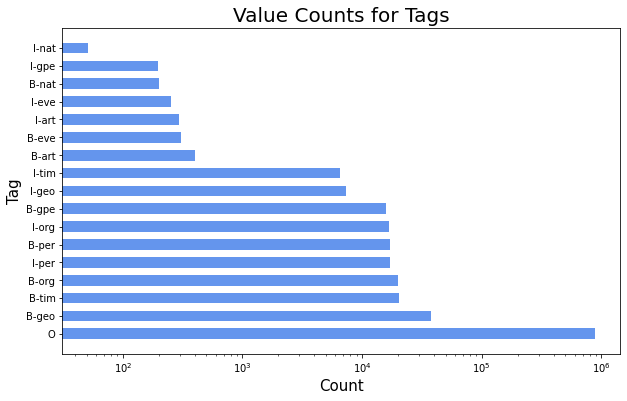

In [ ]:
value_count = data['Tag'].value_counts()
fig, axs = plt.subplots(figsize = (10, 6))
axs.barh(value_count.index, value_count, height = 0.6, color = 'cornflowerblue')
axs.set_ylabel('Tag', fontsize = 15)
axs.set_xlabel('Count', fontsize = 15)
axs.set_xscale('log')
axs.set_title('Value Counts for Tags', fontsize = 20)

In [ ]:
# fill in the empty positions in column Sentence #
sentence_sep = data['Sentence #'].isna()
for i in range(data.shape[0]):
    if sentence_sep[i]:
        data.iloc[i,0] = data.iloc[i-1,0]

In [ ]:
# save imputed dataset to csv
data.to_csv('NER_data/ner_dataset_fill.csv', index=False)

## Start to run from here!

In [ ]:
# read in imputed dataset
df = pd.read_csv('NER_data/ner_dataset_fill.csv', index_col=False, encoding="latin1")

In [ ]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
# check if there are any NAs left
df.isna().any()

Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool

In [ ]:
# Create unique word list, store the list and its length
words = sorted(df['Word'].unique())
words.append('ENDPAD')
words_size = len(words)

# Create unique tag list, store the list and its length
tags = sorted(df['Tag'].unique())
tags.append('PAD')
tags_size = len(tags)

# Create two dictionaries word:word_idx and word_idx:word
word2idx = {value: count for count, value in enumerate(words)}
idx2word = {count: value for value, count in word2idx.items()}

# Create two dictionaries tag:tag_idx and tag_idx:tag
tag2idx = {value: count for count, value in enumerate(tags)}
idx2tag = {count: value for value, count in tag2idx.items()}

In [ ]:
# create list of list where each inner list is the list of word for each sentences
# create list of list where each inner list is the list of tag for each sentences
sentence_group = df.groupby('Sentence #')
sentence_list = []
tag_list = []
count = 1
for sen in sentence_group.groups.keys():
    if count % 5000 == 0:
        print(f'iter: {count}')
    count += 1
    df_group = sentence_group.get_group(sen)
    sentence_list.append(df_group['Word'].tolist())
    tag_list.append(df_group['Tag'].tolist())

iter: 5000
iter: 10000
iter: 15000
iter: 20000
iter: 25000
iter: 30000
iter: 35000
iter: 40000
iter: 45000


In [ ]:
# pick the appropriate sentence length. Here we want to make sure that the majority of our sentences is shorter than our picked length.
# evectually we land on the 99.75% percentile.
max_length = int(np.percentile([len(sen) for sen in sentence_list], 99.75))
num_long_length = len([sen for sen in sentence_list if len(sen) > 40])
print(f'Picked max length for one sentence: {max_length}')
print(f'Number of sentences being trimmed: {num_long_length}')

Picked max length for one sentence: 50
Number of sentences being trimmed: 772


In [ ]:
# set max_length
max_length = 50

## Train Test Split

In [ ]:
# split train-test with ratio 0.1
sent_tr, sent_te, tag_tr, tag_te = train_test_split(sentence_list, tag_list, test_size=0.1, random_state=42)

## LSTM Pre-Processing

In [ ]:
# create list of list where each inner list is the list of word indices for each sentences
# create list of list where each inner list is the list of tag indices for each sentences
X_tr = []
y_tr = []
for i in range(len(sent_tr)):
    X_tr.append(list(map(word2idx.get, sent_tr[i])))
    y_tr.append(list(map(tag2idx.get, tag_tr[i])))

X_te = []
y_te = []
for i in range(len(sent_te)):
    X_te.append(list(map(word2idx.get, sent_te[i])))
    y_te.append(list(map(tag2idx.get, tag_te[i])))

In [ ]:
# pad both our X and y 
X_tr_pad = pad_sequences(sequences = X_tr, maxlen = max_length, padding = 'post', value = word2idx['ENDPAD'])
y_tr_pad = pad_sequences(sequences = y_tr, maxlen = max_length, padding = 'post', value = tag2idx["PAD"])

X_te_pad = pad_sequences(sequences = X_te, maxlen = max_length, padding = 'post', value = word2idx['ENDPAD'])
y_te_pad = pad_sequences(sequences = y_te, maxlen = max_length, padding = 'post', value = tag2idx["PAD"])

In [ ]:
# examine class imbalance in training data
s, count = np.unique(list(np.concatenate(y_tr_pad).flat), return_counts=True)
print(pd.DataFrame(count, index = tags, columns = ['Count']))

         Count
B-art      355
B-eve      272
B-geo    33836
B-gpe    14267
B-nat      179
B-org    18075
B-per    15311
B-tim    18285
I-art      257
I-eve      213
I-geo     6697
I-gpe      182
I-nat       42
I-org    15075
I-per    15584
I-tim     5931
O       798806
PAD    1214783


In [ ]:
# calculate average count per class
np.mean(count)

119897.22222222222

In [ ]:
# one hot encode our target variable
y_tr_pad = to_categorical(y_tr_pad, num_classes=tags_size)

y_te_pad = to_categorical(y_te_pad, num_classes=tags_size)

## Build Bidirectional LSTM Model

In [ ]:
# set parameters for Bidirectional LSTM
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
metrics = ['categorical_accuracy']

batch_size = 32
epochs = 20
validation_split = 0.1
verbose = 1

In [ ]:
# calculate potential class weights for loss based on class imbalance
# didn't use this part eventually
y_tr_int = np.argmax(y_tr_pad, axis=2).flatten()
class_weights = compute_class_weight('balanced', np.unique(y_tr_int), y_tr_int)
class_weights = np.asarray(class_weights)

In [ ]:
# to calculate the standard categorical cross entropy, we set the class weight to all ones
weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

In [ ]:
# define a custom loss function that combines class weights with categorical cross entropy loss
def custom_loss(y_true, y_pred):

  # get the first two dimensions from y_pred
  if y_pred.shape[0] is None:
    x = 1
  else:
    x = int(y_pred.shape[0])
  y = y_pred.shape[1]

  # reshape weight for each batch
  batch_weights = np.array([np.array(weights)] * (x*y))
  batch_weights = batch_weights.reshape(x,y,18)
  batch_weights = tf.cast(batch_weights, tf.float64)

  # cast y_true and y_pred into tf.float64
  y_true = tf.cast(y_true, tf.float64)
  y_pred = tf.cast(y_pred, tf.float64)

  # return weighted categorical cross entropy
  return tf.math.reduce_sum(y_true * batch_weights, axis=-1) * tf.keras.losses.categorical_crossentropy(y_true, y_pred)

In [ ]:
# Build BiLSTM model
model_title = "BiLSTM"
lstm = Sequential()
lstm.add(
    Embedding(
        input_dim = words_size, output_dim = dim_embed, input_length = max_length
    )
)
lstm.add(Dropout(drop_rate))
lstm.add(Bidirectional(LSTM(n_units, return_sequences = True)))
lstm.add(TimeDistributed(Dense(tags_size, activation = 'softmax')))

# Compile model
lstm.compile(optimizer=optimizer, loss=custom_loss, metrics=metrics)

In [ ]:
print(lstm.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_79 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 18)            3618      
Total params: 1,883,368
Trainable params: 1,883,368
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# set early stopping for model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)

callbacks = [early_stopping]

In [ ]:
# fit the model
history = lstm.fit(X_tr_pad, y_tr_pad, batch_size=batch_size, epochs=epochs, 
                  validation_split=validation_split, callbacks=callbacks, verbose=verbose)

Epoch 1/20
1214/1214 [==============================] - 20s 15ms/step - loss: 0.3041 - categorical_accuracy: 0.9265 - val_loss: 0.0626 - val_categorical_accuracy: 0.9816
Epoch 2/20
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0557 - categorical_accuracy: 0.9838 - val_loss: 0.0521 - val_categorical_accuracy: 0.9846
Epoch 3/20
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0446 - categorical_accuracy: 0.9869 - val_loss: 0.0490 - val_categorical_accuracy: 0.9853
Epoch 4/20
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0398 - categorical_accuracy: 0.9882 - val_loss: 0.0476 - val_categorical_accuracy: 0.9857
Epoch 5/20
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0368 - categorical_accuracy: 0.9891 - val_loss: 0.0469 - val_categorical_accuracy: 0.9859
Epoch 6/20
1214/1214 [==============================] - 17s 14ms/step - loss: 0.0339 - categorical_accuracy: 0.9899 - val_loss: 0.0476 - val_categoric

In [ ]:
# Examine performance for  
lstm_pred = lstm.predict(X_te_pad, batch_size = batch_size, verbose = verbose)
lstm_pred_flat = np.argmax(lstm_pred, axis = 2).flatten()
y_te_flat = np.argmax(y_te_pad, axis = 2).flatten()

# display f1 score for each class and 
f1_lstm = f1_score(y_te_flat, lstm_pred_flat, average = None)
print(pd.DataFrame(f1_lstm, index = tags))
print('Mean F1 across classes: ',np.mean(f1_lstm))

150/150 [==============================] - 1s 4ms/step
              0
B-art  0.000000
B-eve  0.266667
B-geo  0.873587
B-gpe  0.950192
B-nat  0.320000
B-org  0.725926
B-per  0.835412
B-tim  0.900000
I-art  0.000000
I-eve  0.000000
I-geo  0.813031
I-gpe  0.666667
I-nat  0.000000
I-org  0.769581
I-per  0.872978
I-tim  0.784965
O      0.990783
PAD    1.000000
Mean F1 across classes:  0.5983215588987709


### Entity-level for LSTM

In [ ]:
lstm_pred_decode = np.argmax(lstm_pred, axis = 2)

In [ ]:
lstm_pred_tag = []
y_true_tag_lstm = []

y_true_te = np.argmax(y_te_pad, axis = 2)

for i in range(len(y_true_te)):
  lstm_pred_tag.append(list(map(idx2tag.get, lstm_pred_decode[i])))
  y_true_tag_lstm.append(list(map(idx2tag.get, y_true_te[i])))

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

In [ ]:
from copy import deepcopy

metrics_results = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0,'recall': 0,}

# overall results
results = {'strict': deepcopy(metrics_results),
           'ent_type': deepcopy(metrics_results),
           
           }

# results aggregated by entity type
evaluation_agg_entities_type_lstm = {e: deepcopy(results) for e in entity_tag}

for true_ents, pred_ents in zip(y_true_tag_lstm, lstm_pred_tag):    
    # compute results for one message
    tmp_results, tmp_agg_results = compute_metrics(collect_named_entities(true_ents),collect_named_entities(pred_ents), entity_tag)

    # aggregate overall results
    for eval_schema in results.keys():
        for metric in metrics_results.keys():
            results[eval_schema][metric] += tmp_results[eval_schema][metric]


    # aggregate results by entity type
    for e_type in entity_tag:
        for eval_schema in evaluation_agg_entities_type_lstm[e_type]:
            for metric in tmp_agg_results[e_type][eval_schema]:
                evaluation_agg_entities_type_lstm[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

In [ ]:
f1_lstm_entity = make_precision_recall(evaluation_agg_entities_type_lstm,'strict')
f1_lstm_entity

{'art': {'f1': 0, 'precision': 0.0, 'recall': 0.0},
 'eve': {'f1': 0.010498687664041995,
  'precision': 0.005415162454873646,
  'recall': 0.17142857142857143},
 'geo': {'f1': 0.7960410038882997,
  'precision': 0.7201023235983799,
  'recall': 0.8898840885142255},
 'gpe': {'f1': 0.6989424206815511,
  'precision': 0.5583927900863688,
  'recall': 0.9340452261306532},
 'nat': {'f1': 0.0071492403932082215,
  'precision': 0.003639672429481347,
  'recall': 0.2},
 'org': {'f1': 0.5622977346278317,
  'precision': 0.48280653004515456,
  'recall': 0.6731234866828087},
 'per': {'f1': 0.592280701754386,
  'precision': 0.4863618901267768,
  'recall': 0.757177033492823},
 'tim': {'f1': 0.7002858309514088,
  'precision': 0.5983949755757153,
  'recall': 0.843996062992126}}

## Build BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

2021-04-21 00:44:19 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 00:44:19 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/vocab.txt HTTP/1.1" 200 0
2021-04-21 00:44:19 filelock DEBUG: Attempting to acquire lock 140519708703888 on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-04-21 00:44:19 filelock INFO: Lock 140519708703888 acquired on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-04-21 00:44:19 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 00:44:19 urllib3.connectionpool DEBUG: https://huggingface.co:443 "GET /bert-base-cased/resolve/main/vocab.txt HTTP/1.1" 200 213450


2021-04-21 00:44:20 filelock DEBUG: Attempting to release lock 140519708703888 on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-04-21 00:44:20 filelock INFO: Lock 140519708703888 released on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock
2021-04-21 00:44:20 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443


2021-04-21 00:44:20 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/added_tokens.json HTTP/1.1" 404 0
2021-04-21 00:44:20 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 00:44:20 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
2021-04-21 00:44:20 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 00:44:20 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2021-04-21 00:44:20 filelock DEBUG: Attempting to acquire lock 140517862472912 on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
2021-04-21 00:44:20 filelock INFO: Lock 140517862472912 acquired on /root/.cache/huggi

2021-04-21 00:44:21 filelock DEBUG: Attempting to release lock 140517862472912 on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
2021-04-21 00:44:21 filelock INFO: Lock 140517862472912 released on /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
2021-04-21 00:44:21 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443


2021-04-21 00:44:21 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tokenizer.json HTTP/1.1" 200 0
2021-04-21 00:44:21 filelock DEBUG: Attempting to acquire lock 140519709519248 on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
2021-04-21 00:44:21 filelock INFO: Lock 140519709519248 acquired on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
2021-04-21 00:44:21 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 00:44:21 urllib3.connectionpool DEBUG: https://huggingface.co:443 "GET /bert-base-cased/resolve/main/tokenizer.json HTTP/1.1" 200 435797


2021-04-21 00:44:22 filelock DEBUG: Attempting to release lock 140519709519248 on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock
2021-04-21 00:44:22 filelock INFO: Lock 140519709519248 released on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
def make_precision_recall(entity_level_dict, scheme):
  bert_entity_result = {}
  for tag in entity_level_dict.keys():
    if tag not in bert_entity_result.keys():
      bert_entity_result[tag] = {}
    bert_entity_result[tag]['precision'] = entity_level_dict[tag][scheme]['correct'] / entity_level_dict[tag][scheme]['actual'] 
    bert_entity_result[tag]['recall'] = entity_level_dict[tag][scheme]['correct'] / entity_level_dict[tag][scheme]['possible']
    if bert_entity_result[tag]['recall'] + bert_entity_result[tag]['precision'] != 0:
      bert_entity_result[tag]['f1'] = 2 * bert_entity_result[tag]['precision'] * bert_entity_result[tag]['recall'] / (bert_entity_result[tag]['recall'] + bert_entity_result[tag]['precision'])
    else:
      bert_entity_result[tag]['f1'] = 0
  return bert_entity_result

In [ ]:
tokenized_texts_and_labels_tr = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sent_tr, tag_tr)
]

tokenized_texts_and_labels_te = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sent_te, tag_te)
]

In [ ]:
tokenized_texts_tr = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_tr]
labels_tr = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_tr]

tokenized_texts_te = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_te]
labels_te = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_te]

In [ ]:
tr_inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_tr],
                          maxlen=max_length, dtype="long", value=word2idx['ENDPAD'],
                          truncating="post", padding="post")

te_inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_te],
                          maxlen=max_length, dtype="long", value=word2idx['ENDPAD'],
                          truncating="post", padding="post")

In [ ]:
tr_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_tr],
                     maxlen=max_length, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

te_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_te],
                     maxlen=max_length, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
tr_masks = [[float(i != word2idx['ENDPAD']) for i in ii] for ii in tr_inputs]

te_masks = [[float(i != word2idx['ENDPAD']) for i in ii] for ii in te_inputs]

In [ ]:
tr_inputs = tf.convert_to_tensor(tr_inputs)
te_inputs = tf.convert_to_tensor(te_inputs)
tr_tags = tf.convert_to_tensor(tr_tags)
te_tags = tf.convert_to_tensor(te_tags)
tr_masks = tf.convert_to_tensor(tr_masks)
te_masks = tf.convert_to_tensor(te_masks)

In [ ]:
# train_data = tf.data.Dataset(tr_inputs, tr_masks, tr_tags)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# valid_data = TensorDataset(val_inputs, val_masks, val_tags)
# valid_sampler = SequentialSampler(valid_data)
# valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(((tr_inputs, 
                                                  tr_masks), 
                                                 tr_tags))

val_data = tf.data.Dataset.from_tensor_slices(((te_inputs, 
                                                  te_masks), 
                                               te_tags))

In [ ]:
BATCH_SIZE = 32
TRAIN_SHUFFLE_BUFFER_SIZE = len(tr_tags)
VAL_SHUFFLE_BUFFER_SIZE = len(te_tags)
PREFETCH_BUFFER_SIZE = 100

# Transfer training data
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size=BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

# Transfer validation data
val_data = val_data.batch(batch_size=BATCH_SIZE)
val_data = val_data.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

print('train_data: ', train_data)
print('val_data: ', val_data)

train_data:  <PrefetchDataset shapes: (((None, 50), (None, 50)), (None, 50)), types: ((tf.int64, tf.float32), tf.int64)>
val_data:  <PrefetchDataset shapes: (((None, 50), (None, 50)), (None, 50)), types: ((tf.int64, tf.float32), tf.int64)>


In [ ]:
bert = TFBertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

2021-04-21 01:32:23 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 01:32:24 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/config.json HTTP/1.1" 200 0
2021-04-21 01:32:24 urllib3.connectionpool DEBUG: Starting new HTTPS connection (1): huggingface.co:443
2021-04-21 01:32:24 urllib3.connectionpool DEBUG: https://huggingface.co:443 "HEAD /bert-base-cased/resolve/main/tf_model.h5 HTTP/1.1" 302 0
All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
FULL_FINETUNING = True
if False:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
# total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0
#     num_training_steps=total_steps
# )

In [ ]:
import keras
optimizer = keras.optimizers.Adam(lr=3e-5)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
bert.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Callbacks
# Learning Rate Scheduler: Change learning rates during training epochs
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * 0.01
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# Early Stopping: Stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto'
)
callbacks = [lr_scheduler,early_stopping]



In [ ]:
import time
start_time = time.time()
training_results = bert.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs, 
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/10


2021-04-21 01:32:37 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-04-21 01:32:37 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-04-21 01:32:43 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-04-21 01:32:43 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1349/1349 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9348WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-04-21 01:35:39 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-04-21 01:35:39 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1349/1349 [==============================] - 192s 130ms/step - loss: 0.2556 - accuracy: 0.9348 - val_loss: 0.0682 - val_accuracy: 0.9789
Epoch 2/10
1349/1349 [==============================] - 173s 128ms/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.0641 - val_accuracy: 0.9798
Epoch 3/10
1349/1349 [==============================] - 173s 128ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.0637 - val_accuracy: 0.9810
Epoch 4/10
1349/1349 [==============================] - 173s 128ms/step - loss: 0.0338 - accuracy: 0.9890 - val_loss: 0.0673 - val_accuracy: 0.9803
Epoch 5/10
1349/1349 [==============================] - 173s 128ms/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0753 - val_accuracy: 0.9810
Epoch 6/10
1349/1349 [==============================] - 173s 128ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0773 - val_accuracy: 0.9809
Training execution time (mins) 17.63031930923462


In [ ]:
bert_logit = bert.predict(val_data)
bert_pred_flat = bert_logit[0].argmax(axis=2).flatten()

2021-04-21 03:20:49 tensorflow WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-04-21 03:20:49 tensorflow WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
f1_bert = f1_score(te_tags.numpy().flatten(), bert_pred_flat, average = None)
print(pd.DataFrame(f1_bert, index = tags))
print('Mean F1 across classes: ',np.mean(f1_bert))

              0
B-art  0.236842
B-eve  0.354430
B-geo  0.885323
B-gpe  0.944633
B-nat  0.232558
B-org  0.770604
B-per  0.853482
B-tim  0.889844
I-art  0.065574
I-eve  0.225806
I-geo  0.782937
I-gpe  0.789474
I-nat  0.444444
I-org  0.772833
I-per  0.887477
I-tim  0.800646
O      0.990599
PAD    1.000000
Mean F1 across classes:  0.6626392942881936


### Entity Level F-1 for BERT

In [ ]:
bert_pred = bert_logit[0].argmax(axis=2)

In [ ]:
bert_pred_tag = []
y_true_tag = []
y_true_te = te_tags.numpy()

for i in range(len(bert_pred)):
  bert_pred_tag.append(list(map(idx2tag.get, bert_pred[i])))
  y_true_tag.append(list(map(idx2tag.get, y_true_te[i])))

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

In [ ]:
from copy import deepcopy

metrics_results = {'correct': 0, 'incorrect': 0, 'partial': 0,
                   'missed': 0, 'spurious': 0, 'possible': 0, 'actual': 0, 'precision': 0,'recall': 0,}

# overall results
results = {'strict': deepcopy(metrics_results),
           'ent_type': deepcopy(metrics_results),
           
           }

# results aggregated by entity type
evaluation_agg_entities_type = {e: deepcopy(results) for e in entity_tag}

for true_ents, pred_ents in zip(y_true_tag, bert_pred_tag):    
    # compute results for one message
    tmp_results, tmp_agg_results = compute_metrics(collect_named_entities(true_ents),collect_named_entities(pred_ents), entity_tag)

    # aggregate overall results
    for eval_schema in results.keys():
        for metric in metrics_results.keys():
            results[eval_schema][metric] += tmp_results[eval_schema][metric]


    # aggregate results by entity type
    for e_type in entity_tag:
        for eval_schema in evaluation_agg_entities_type[e_type]:
            for metric in tmp_agg_results[e_type][eval_schema]:
                evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

In [ ]:
f1_bert_entity = make_precision_recall(evaluation_agg_entities_type,'strict')
f1_bert_entity

{'art': {'f1': 0.01937046004842615,
  'precision': 0.010462074978204011,
  'recall': 0.13043478260869565},
 'eve': {'f1': 0.018787361229718195,
  'precision': 0.00975177304964539,
  'recall': 0.2558139534883721},
 'geo': {'f1': 0.8403898872982029,
  'precision': 0.7894134477825465,
  'recall': 0.8984044285249104},
 'gpe': {'f1': 0.7182462927143778,
  'precision': 0.5826359832635983,
  'recall': 0.9361344537815126},
 'nat': {'f1': 0.01054481546572935,
  'precision': 0.005385996409335727,
  'recall': 0.25},
 'org': {'f1': 0.6558954119388258,
  'precision': 0.5984695025883412,
  'recall': 0.7255115961800819},
 'per': {'f1': 0.7037150752225975,
  'precision': 0.6154672395273899,
  'recall': 0.821505376344086},
 'tim': {'f1': 0.7075579187238892,
  'precision': 0.6130306021717671,
  'recall': 0.8365514144589133}}

In [ ]:
f1_word_level = {}

y_te_flat = np.argmax(y_te_pad, axis = 2).flatten()

# Baseline model
f1_word_level['Bi-LSTM'] = f1_lstm
f1_word_level['BERT'] = f1_bert

print(f1_word_level['Bi-LSTM'])
print(f1_word_level['BERT'])

[0.         0.26666667 0.87358684 0.95019157 0.32       0.72592593
 0.83541223 0.9        0.         0.         0.81303116 0.66666667
 0.         0.76958132 0.87297783 0.78496503 0.99078281 1.        ]
[0.23684211 0.35443038 0.88532258 0.94463277 0.23255814 0.7706044
 0.8534825  0.88984393 0.06557377 0.22580645 0.78293737 0.78947368
 0.44444444 0.77283264 0.88747706 0.80064568 0.99059941 1.        ]


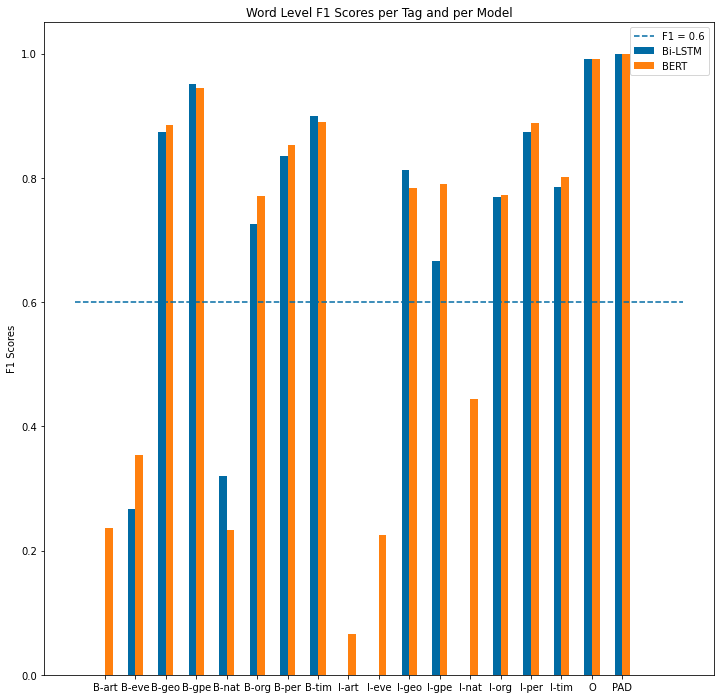

In [ ]:
labels = list(idx2tag.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12,12))
rects1 = ax.bar(x - width * 0.5, f1_word_level['Bi-LSTM'], width, label = 'Bi-LSTM')
rects2 = ax.bar(x + width * 0.5, f1_word_level['BERT'], width, label = 'BERT')
ax.plot(np.arange(-1, 20, step = 1), [0.6] * 21, '--', label = 'F1 = 0.6')

ax.set_ylabel('F1 Scores')
ax.set_title('Word Level F1 Scores per Tag and per Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig('wrd_f1.png')
plt.show()

In [ ]:
f1_entity_level = {}

f1_lstm_entity_list = []
f1_bert_entity_list = []
for key in f1_lstm_entity.keys():
  f1_lstm_entity_list.append(f1_lstm_entity[key]['f1'])
  f1_bert_entity_list.append(f1_bert_entity[key]['f1'])


# Baseline model
f1_entity_level['Bi-LSTM'] = f1_lstm_entity_list
f1_entity_level['BERT'] = f1_bert_entity_list

In [ ]:
np.mean(f1_lstm_entity_list)

0.420936952495091

In [ ]:
np.mean(f1_bert_entity_list)

0.45931340283022093

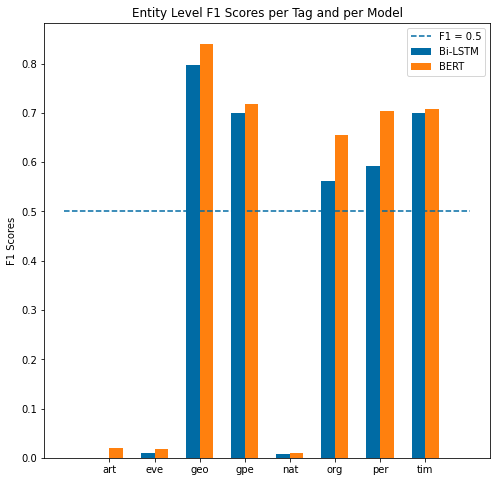

In [ ]:
entity_tag = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

x = np.arange(len(entity_tag))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - width * 0.5, f1_entity_level['Bi-LSTM'], width, label = 'Bi-LSTM')
rects2 = ax.bar(x + width * 0.5, f1_entity_level['BERT'], width, label = 'BERT')
ax.plot(np.arange(-1, 9, step = 1), [0.5] * 10, '--', label = 'F1 = 0.5')

ax.set_ylabel('F1 Scores')
ax.set_title('Entity Level F1 Scores per Tag and per Model')
ax.set_xticks(x)
ax.set_xticklabels(entity_tag)
ax.legend()
plt.savefig('ent_f1.png')
plt.show()